In [3]:
import torch
import numpy as np
import models.networks as nets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
model = nets.cDCGANGenerator(input_nz=128, output_nc=1, ngf=32)
# Load the model
model.load_state_dict(torch.load('checkpoints/mnistUniqueFashionUniform_UAGAN_10D/latest_net_G.pth'))
model.eval()

cDCGANGenerator(
  (deconv1_1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (deconv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_2): ConvTranspose2d(10, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (deconv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

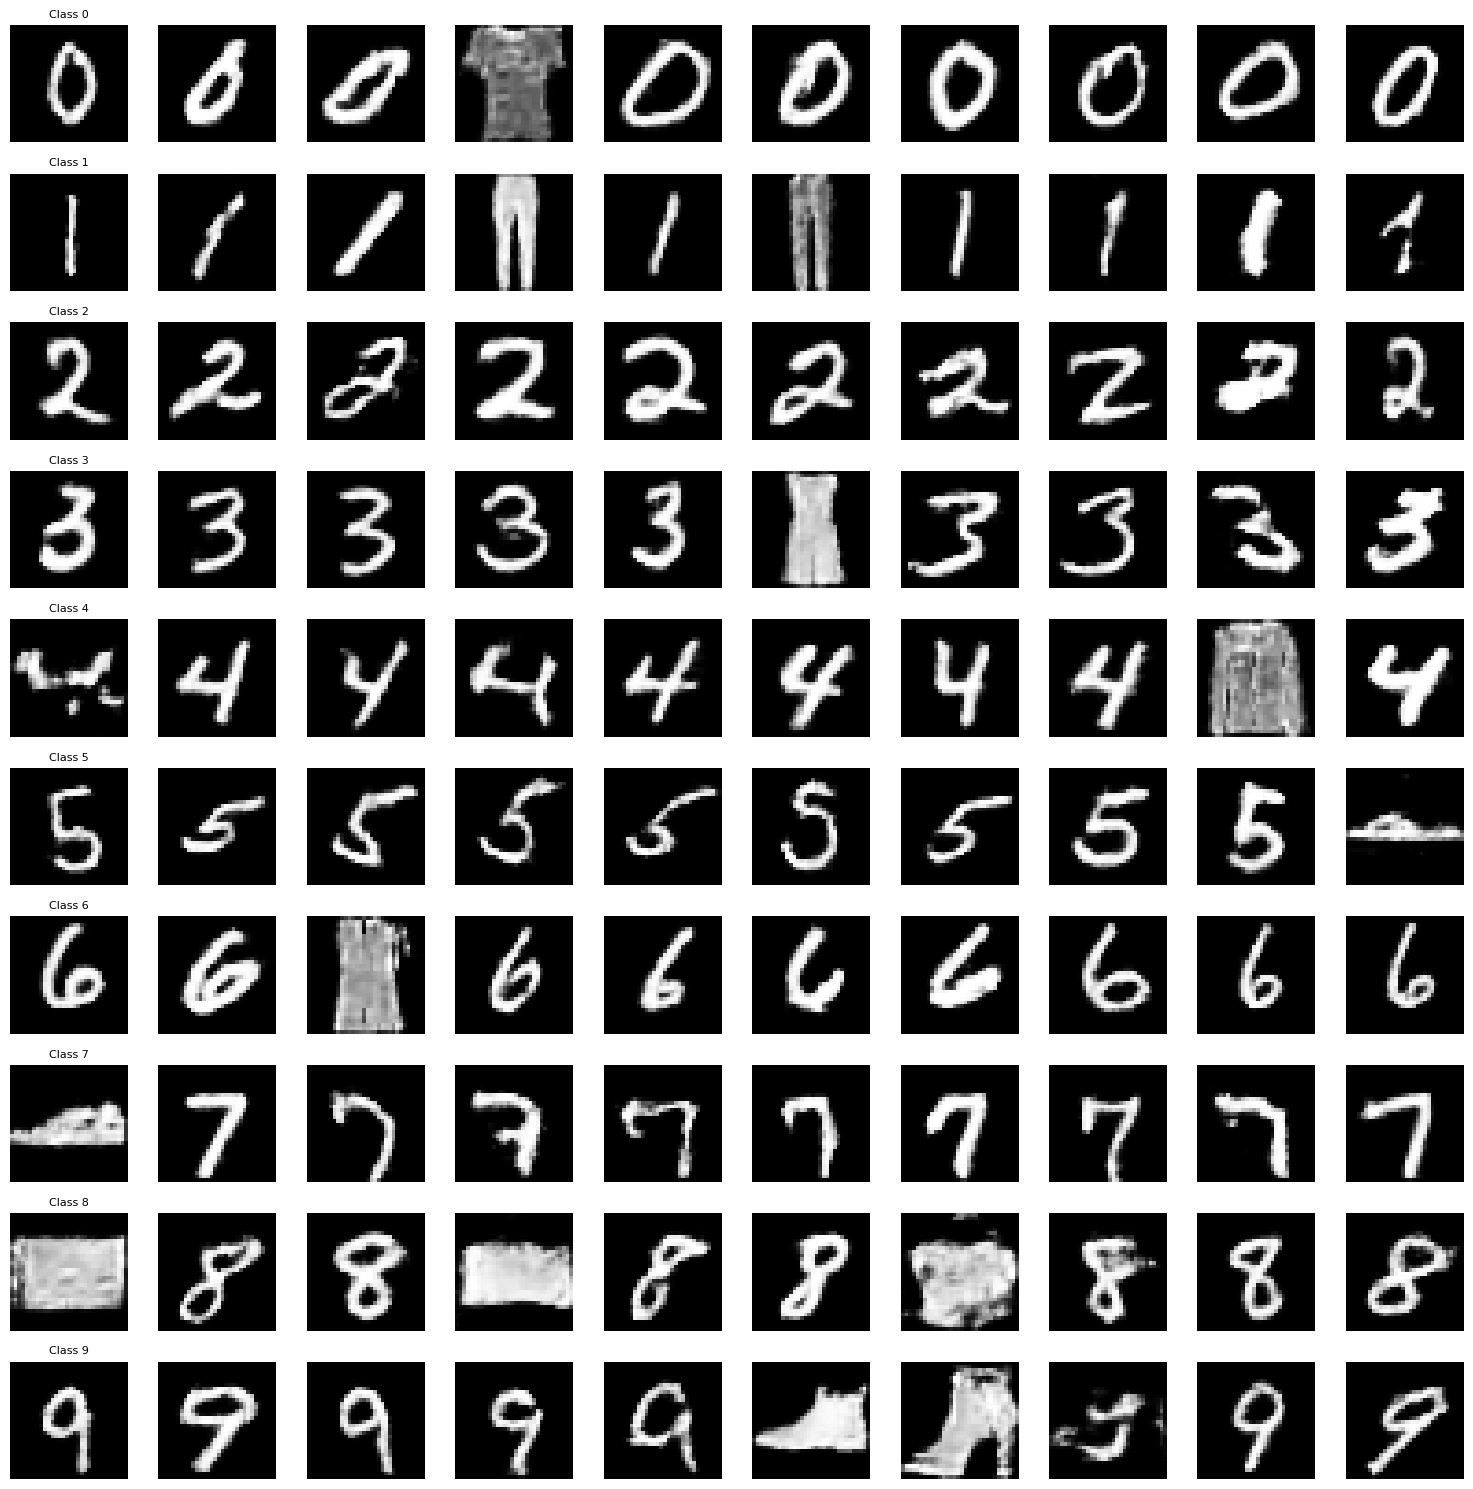

In [20]:
# parameters
n_classes  = 10
n_per_cls  = 10
latent_dim = 128

# 1) sample one batch of noise of size 10*5
batch_size = n_classes * n_per_cls
z = torch.randn(batch_size, latent_dim, 1, 1)

# 2) build labels: [0,0,0,0,0, 1,1,1,1,1, 2,2,...,9,9]
labels = torch.arange(n_classes).unsqueeze(1).repeat(1, n_per_cls).view(-1)

# 3) one-hot encode and reshape to (B,10,1,1)
labels_onehot = F.one_hot(labels, num_classes=n_classes).float().view(batch_size, n_classes, 1, 1)

# 4) generate images
model.eval()
with torch.no_grad():
    fake_images = model(z, labels_onehot)  # (50, C, H, W)

# 5) plot in a 10 x 5 grid
fake_np = fake_images.cpu().numpy()
fig, axes = plt.subplots(n_classes, n_per_cls, figsize=(n_per_cls*1.5, n_classes*1.5))

for cls in range(n_classes):
    for i in range(n_per_cls):
        idx = cls * n_per_cls + i
        img = fake_np[idx].transpose(1,2,0)  # (H,W,C)
        #img = (img + 1) / 2                  # rescale from [-1,1] → [0,1]
        axes[cls, i].imshow(img, cmap="gray")
        axes[cls, i].axis('off')
        if i == 0:
                axes[cls, i].set_title(f"Class {cls}", fontsize=8)

plt.tight_layout()
plt.show()

In [1]:
import os
import re

# Defina aqui o caminho da pasta onde estão os arquivos
diretorio = r"/Users/Mara/Documents/Mestrado/Pesquisa/UA/UAGAN/checkpoints/mnistUniqueFashionUniform_UAGAN_10D"
diretorio_novo = r"/Users/Mara/Documents/Mestrado/Pesquisa/UA/UAGAN/checkpoints/mnistUniqueFashionUniform_UAGAN_10D/Imbalanced(MNIST_NIDD FMNIST_IID)"

# Expressão regular para capturar o número inicial e o restante do nome
padrao = re.compile(r"^(\d+)(.*)$")

for nome_antigo in os.listdir(diretorio):
    caminho_antigo = os.path.join(diretorio, nome_antigo)
    # só atuamos em arquivos (não em pastas)
    if not os.path.isfile(caminho_antigo):
        continue

    m = padrao.match(nome_antigo)
    if m:
        numero = int(m.group(1))
        resto = m.group(2)
        novo_numero = numero + 700
        nome_novo = f"{novo_numero}{resto}"
        caminho_novo = os.path.join(diretorio_novo, nome_novo)

        # Evita sobrescrever sem querer
        if os.path.exists(caminho_novo):
            print(f"Atenção: {nome_novo} já existe, pulando.")
        else:
            print(f"{nome_antigo} → {nome_novo}")
            os.rename(caminho_antigo, caminho_novo)


150_net_G.pth → 850_net_G.pth
400_net_G.pth → 1100_net_G.pth
100_net_G.pth → 800_net_G.pth
300_net_D_4.pth → 1000_net_D_4.pth
250_net_D_5.pth → 950_net_D_5.pth
200_net_G.pth → 900_net_G.pth
400_net_D_0.pth → 1100_net_D_0.pth
150_net_D_0.pth → 850_net_D_0.pth
150_net_D_1.pth → 850_net_D_1.pth
400_net_D_1.pth → 1100_net_D_1.pth
250_net_D_4.pth → 950_net_D_4.pth
300_net_D_5.pth → 1000_net_D_5.pth
300_net_D_7.pth → 1000_net_D_7.pth
50_net_D_8.pth → 750_net_D_8.pth
200_net_D_9.pth → 900_net_D_9.pth
250_net_D_6.pth → 950_net_D_6.pth
350_net_D_8.pth → 1050_net_D_8.pth
400_net_D_3.pth → 1100_net_D_3.pth
150_net_D_3.pth → 850_net_D_3.pth
150_net_D_2.pth → 850_net_D_2.pth
400_net_D_2.pth → 1100_net_D_2.pth
350_net_D_9.pth → 1050_net_D_9.pth
250_net_D_7.pth → 950_net_D_7.pth
200_net_D_8.pth → 900_net_D_8.pth
50_net_D_9.pth → 750_net_D_9.pth
300_net_D_6.pth → 1000_net_D_6.pth
300_net_D_2.pth → 1000_net_D_2.pth
100_net_D_9.pth → 800_net_D_9.pth
250_net_D_3.pth → 950_net_D_3.pth
400_net_D_6.pth → 11